In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from pandas_datareader import data as pdr
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import statsmodels.api as sm
from sklearn.metrics import r2_score
from fastai.tabular.all import add_datepart
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import math
import time

tic = time.time()

In [2]:
# # read the stock data at the first run
# # to download the data, need the vpn
# # comment the following codes after the first run
# yf.pdr_override()
# data = pdr.get_data_yahoo("AAPL", start="2022-01-01", end="2023-05-30")
# data # there are 352 data in total using as training and validation data
# data.to_csv('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/AAPL.csv')

In [3]:
# uncomment this block only after the first run
data = pd.read_csv('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/AAPL.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2022-01-03 to 2023-05-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       352 non-null    float64
 1   High       352 non-null    float64
 2   Low        352 non-null    float64
 3   Close      352 non-null    float64
 4   Adj Close  352 non-null    float64
 5   Volume     352 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 19.2 KB


In [4]:
data_2 = pd.DataFrame({'Close':data['Close']})
data_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2022-01-03 to 2023-05-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   352 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB


In [5]:
data_2.asfreq("D")[:15]

,Close
Date,
2022-01-03,182.009995
2022-01-04,179.699997
2022-01-05,174.919998
2022-01-06,172.000000
2022-01-07,172.169998
2022-01-08,NaN
2022-01-09,NaN
2022-01-10,172.190002
2022-01-11,175.080002


In [6]:
data_2.asfreq("D", method="ffill")[:15]

,Close
Date,
2022-01-03,182.009995
2022-01-04,179.699997
2022-01-05,174.919998
2022-01-06,172.000000
2022-01-07,172.169998
2022-01-08,172.169998
2022-01-09,172.169998
2022-01-10,172.190002
2022-01-11,175.080002


In [7]:
data_2 = data_2.asfreq("D", method='ffill')
data_2

,Close
Date,
2022-01-03,182.009995
2022-01-04,179.699997
2022-01-05,174.919998
2022-01-06,172.000000
2022-01-07,172.169998
...,...
2023-05-22,174.199997
2023-05-23,171.559998
2023-05-24,171.839996


<Axes: xlabel='Date'>

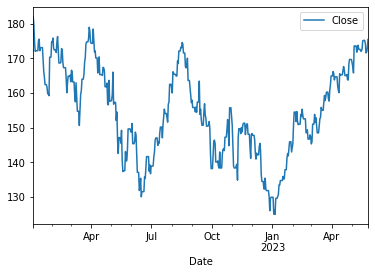

In [8]:
data_2.plot()

In [9]:
# Testing for stationarity
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data_2)

(0.6612731932801885, True)

In [10]:
# Spliting the dataset into train and test
train, test = data_2[:int(len(data_2)*0.9)].copy(), data_2[int(len(data_2)*0.9):].copy()

In [11]:
len(test)

51

In [12]:
train.tail()

,Close
Date,
2023-04-01,164.899994
2023-04-02,164.899994
2023-04-03,166.169998
2023-04-04,165.630005
2023-04-05,163.759995


In [13]:
test.head()

,Close
Date,
2023-04-06,164.660004
2023-04-07,164.660004
2023-04-08,164.660004
2023-04-09,164.660004
2023-04-10,162.029999


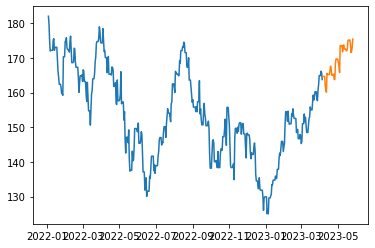

In [14]:
plt.figure()
plt.plot(train)
plt.plot(test)
# plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/train-test')

In [15]:
arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2444.494, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2322.878, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2443.002, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2281.658, Time=0.43 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=2262.384, Time=0.61 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=2242.787, Time=1.20 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=2226.807, Time=5.12 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=34.59 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=12.64 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=2225.608, Time=2.01 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=2242.063, Time=0.90 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=inf, Time=21.70 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=13.77 sec
 ARIMA(0,1,1)(5,1,0)[12]             : A

In [16]:
par_map = arima_model.get_params()
a, b, c = par_map['order'][0], par_map['order'][1], par_map['order'][2]

In [17]:
# check the Best model: ARIMA(1,1,1)(5,1,0)[12]
model = sm.tsa.arima.ARIMA(train, order=(a, b, c))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  458
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1095.461
Date:                Mon, 19 Jun 2023   AIC                           2192.923
Time:                        20:32:49   BIC                           2197.048
Sample:                    01-03-2022   HQIC                          2194.548
                         - 04-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.0728      0.308     22.970      0.000       6.469       7.676
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):               133.10
Prob(Q):                              0.40   Pr

In [18]:
# Summary of the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  458
Model:             SARIMAX(0, 1, 0)x(5, 1, 0, 12)   Log Likelihood               -1106.804
Date:                            Mon, 19 Jun 2023   AIC                           2225.608
Time:                                    20:32:49   BIC                           2250.197
Sample:                                01-03-2022   HQIC                          2235.304
                                     - 04-05-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8171      0.047    -17.454      0.000      -0.909      -0.725
ar.S.L24      -0.6396      0.054    -11.947      0.000      -0.745      -0.535
ar.S.L36      -0.4987      0.057     -8.776      0.000      -0.610      -0.387
ar.S.L48      -0.3839      0.063     -6.090      0.000      -0.507      -0.260
ar.S.L60      -0.2075      0.049     -4.264      0.000      -0.303      -0.112
sigma2         8.2299      0.430     19.133      0.000       7.387       9.073
===================================================================================
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):                53.81
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 51),index=test.index)
prediction.columns = ['predicted_price']
prediction.tail()

,predicted_price
Date,
2023-05-22,176.837392
2023-05-23,176.599210
2023-05-24,176.921599
2023-05-25,177.446212
2023-05-26,177.979911


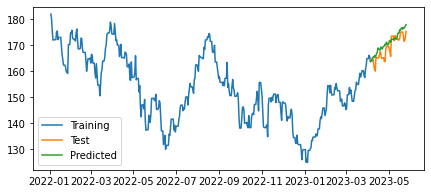

In [20]:
plt.figure(figsize=(7,3))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'best')
# plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/test/TimeSeries_Auto-ARIMA/prediction.png')

In [21]:
test['predicted_price'] = prediction
r2_score(test['Close'], test['predicted_price'])

0.5103764223378233

In [22]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 7))
prediction.columns = ['predicted_price']
print(prediction.to_latex())
prediction

\begin{tabular}{lr}
\toprule
{} &  predicted\_price \\
\midrule
2023-04-06 &       163.974933 \\
2023-04-07 &       163.808071 \\
2023-04-08 &       165.191158 \\
2023-04-09 &       165.510559 \\
2023-04-10 &       165.277876 \\
2023-04-11 &       166.037471 \\
2023-04-12 &       165.636118 \\
\bottomrule
\end{tabular}



,predicted_price
2023-04-06,163.974933
2023-04-07,163.808071
2023-04-08,165.191158
2023-04-09,165.510559
2023-04-10,165.277876
2023-04-11,166.037471
2023-04-12,165.636118


In [26]:
# final result for future 7 days
prediction = pd.DataFrame(arima_model.predict(n_periods = 58))
prediction.columns = ['predicted_price']
prediction.tail(7)

,predicted_price
2023-05-27,178.602669
2023-05-28,178.751987
2023-05-29,179.657233
2023-05-30,180.060537
2023-05-31,180.796000
2023-06-01,181.409009
2023-06-02,181.230944


In [27]:
real = data.loc['2023-05-26', 'Close']
pred = prediction.loc['2023-06-02', 'predicted_price']
perc = (pred - real) / real * 100
print("The precentage of the future 7th day's price is higher than the prediction day is {0:.2f}%".format(perc))

The precentage of the future 7th day's price is higher than the prediction day is 3.31%


In [24]:
toc = time.time()
print("Total running time is {0:.2f} min".format((toc - tic) / 60))

Total running time is 1.94 min
